# Motion detection in fruit fly

We train a 2 layer ReSU network to demonstrat that it can perform non trivial motion detection. Input to the network is luminance contrast generated by scanning natural images. The raw gray scale images were first smoothed with a 2D Gaussian filter to mimic the physical properties of the fly's eye. Local contrast was then computed by method described in Chen et al. eLife 2019.

The natural scene data set we used is from Meyer et al. 2014,  and can be downladed from [here](https://pub.uni-bielefeld.de/record/2689637).

The method to get the contrast from luminance is also outlined [here](https://elifesciences.org/articles/47579) and [here](https://jov.arvojournals.org/article.aspx?articleid=2761144): contrast is locally computed based on first spatially blurring to match the spatial acceptance functions of fly photoreceptors, and then subtracting a local estimate of mean luminance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import hankel,sqrtm
# from scipy.stats import zscore
import scipy as sp
import sys
sys.path.append('./utils')
%config InlineBackend.figure_format='retina'
%matplotlib inline

In [2]:
# ---------------------------
# Helper function for z-scoring
# ---------------------------
def zscore(x):
    return (x - np.mean(x)) / np.std(x)

# Normalize and add noise
def normalize_and_noise(x, noise_level=0.01):
    return x / np.std(x) + np.random.randn(len(x)) * noise_level



## Natural scences

### Meyer 2014 dataset

In [3]:
import h5py

# Change the following path to the location of the data on your machine
meyer_data_folder = '/Users/shawnqin/Documents/dropbox_simons/Projects/data/meyer2014_data/savedData/'

# raw and contrast
img_file = 'combinedFiltered2D.mat'

# filtered images
img_filtered_file = 'filteredScenes.mat'

# Open the MATLAB v7.3 file
with h5py.File(meyer_data_folder + img_file, 'r') as file:
    imgs = file['scenes'][:]
    contrast = file['finalContrast'][:]

# load the filtered images
with h5py.File(meyer_data_folder + img_filtered_file, 'r') as file:
    imgs_filtered = file['filteredScenes'][:]

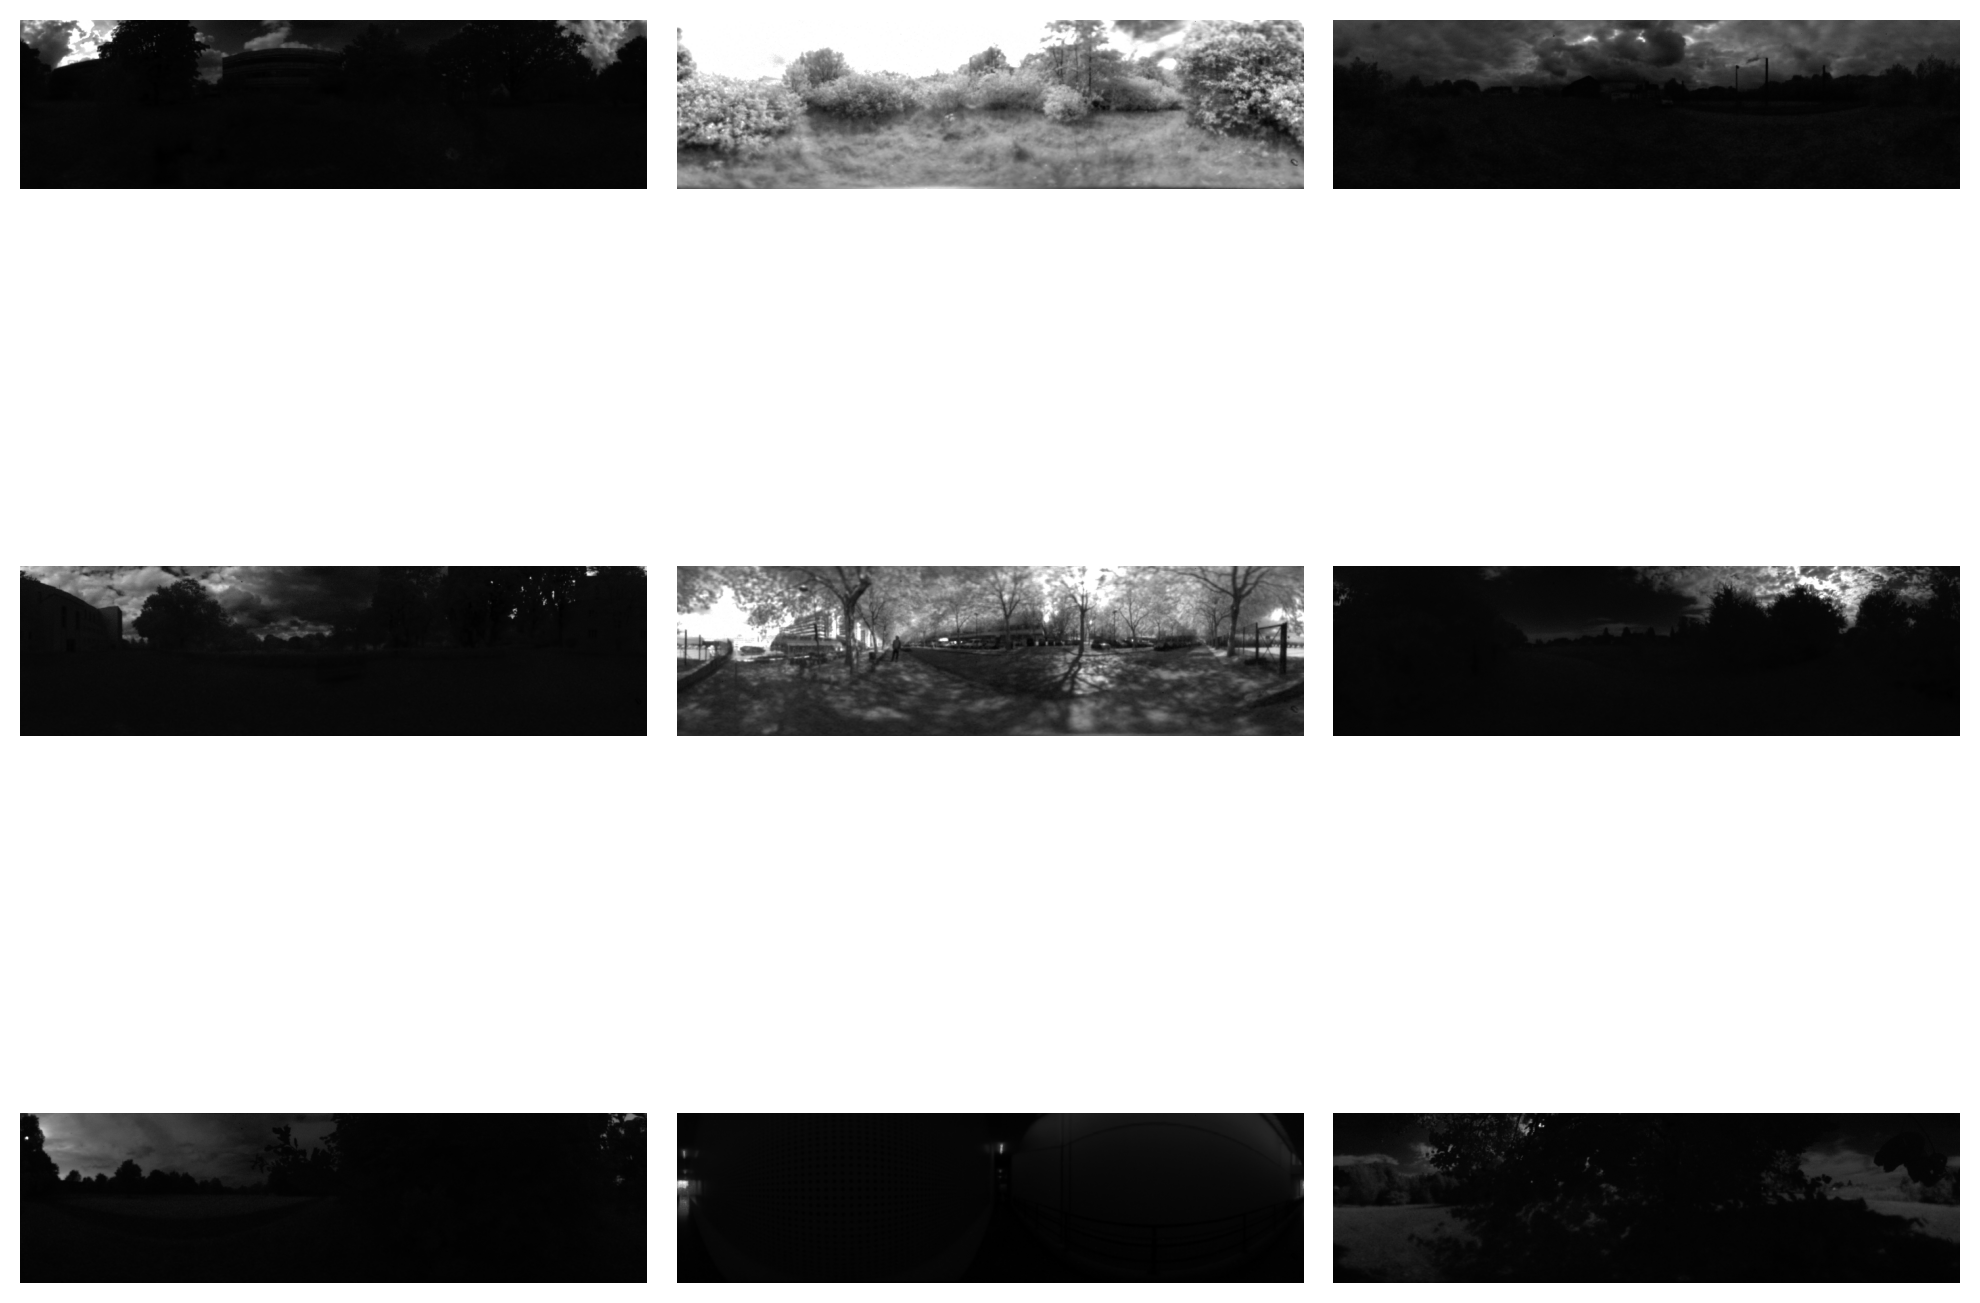

In [4]:
# randomly select 9 images to show
sel = np.random.randint(0,imgs.shape[0],9)
imgs_sel = imgs[sel,:,:]
contrast_sel = contrast[sel,:,:]
# imgs_filtered_sel = imgs_filtered[sel,:,:,:]
# imgs_sel.shap
# # make a 3 by 3 grid of the images
plt.close()
fig, ax = plt.subplots(3,3,figsize=(10,10))
for i in range(9):
    ax[i//3,i%3].imshow(imgs[sel[i],:,:].T, cmap='gray')
    ax[i//3,i%3].axis('off')
# tight layout
plt.tight_layout()
plt.show()  

In [5]:
# smoothed = True
# # row_sel =  [30,70] # add one more row 
# if smoothed:
#     # smooth the contrast
#     contr_sel = contrast[:,:,row_sel].flatten()
#     contr_raw = contrast[:,:,row_sel]
# else:
#     contr_sel = new_contrast
row_sel = 30
contr_sel = contrast[:,:,row_sel].flatten()
contr_raw = contrast[:,:,row_sel]

### First layer

In [6]:
# define the past future related matrices

def past_future_single(contr_sel, memory,horizon):
    lag = memory + horizon
    H = sp.linalg.hankel(contr_sel[:lag],contr_sel[lag-1:])
    num_sample = H.shape[1]
    P = H[:memory,:]
    P = np.flipud(P)
    # Past.append(P)
    F = H[memory:,:]
    Q = F@P.T/num_sample
    # Compute SVD of partially whittened covariance
    Rp = P@P.T/num_sample
    Rf = F@F.T/num_sample
    Rp_half = sqrtm(Rp)
    Rf_half = sqrtm(Rf)
    # Rp_half = cholesky(Rp)
    # Rf_half = cholesky(Rf)
    return Q, Rp_half, Rf_half,P,F

# input is a slist of contrast
def past_future_multi(contrast, memory,horizon):
    lag = memory + horizon
    Ps = []
    Fs = []
    Q = 0
    Rp = 0 
    Rf = 0
    count = 0
    for contr_sel in contrast:
        H = sp.linalg.hankel(contr_sel[:lag],contr_sel[lag-1:])
        num_sample = H.shape[1]
        P = H[:memory,:]
        P = np.flipud(P)
        # Past.append(P)
        F = H[memory:,:]
        Q += F@P.T/num_sample
        Rp += P@P.T/num_sample
        Rf += F@F.T/num_sample
        # Qs.append(Q)
        Ps.append(P)
        Fs.append(F)
        count += 1
        # Compute SVD of partially whittened covariance
    # transform them into array
    P = np.hstack(Ps)
    F = np.hstack(Fs)
    Q = Q/count
    Rp = Rp/count
    Rf = Rf/count
    # Q = np.hstack(Qs)
    # Rp = P@P.T/P.shape[1]
    # Rf = F@F.T/F.shape[1]
    Rp_half = sqrtm(Rp)
    Rf_half = sqrtm(Rf)
    return Q, Rp_half, Rf_half,P,F

# CCA 
def cca_analysis(Q, Rp_half, Rf_half):
    # objective function
    W3 = np.linalg.inv(Rf_half)@Q@np.linalg.inv(Rp_half).T
    W3 = np.real(W3)
    U3, S3, Vh3 = sp.linalg.svd(W3,full_matrices=False)
    filter3 = Vh3@np.linalg.inv(Rp_half)
    return filter3

In [7]:
# subsample the contrast
degree_per_pixel = contrast.shape[1] / 360
sub_rate = 1
contr_sub = contr_sel[::sub_rate]
memory = 50
horizon = 50
noise_std = 0.05
# normalizaion and add noise
contr_sel_noise = (contr_sub - np.mean(contr_sub))/np.std(contr_sub) + noise_std*np.random.randn(contr_sub.shape[0])
# normalize each row of contr_raw
contr_raw_norm = (contr_raw - np.mean(contr_raw, axis=1, keepdims=True)) / np.std(contr_raw, axis=1, keepdims=True)
# add gaussian noise
contr_raw_noise = contr_raw_norm + noise_std * np.random.randn(contr_raw.shape[0], contr_raw.shape[1])
Q_train, Rp_half, Rf_half,P_train,F_train = past_future_multi(contr_raw_noise, memory,horizon)
# Explicit compute the objective function and its SVD
W3 = np.linalg.inv(Rf_half)@Q_train@np.linalg.inv(Rp_half).T
W3 = np.real(W3)
U3, S3, Vh3 = sp.linalg.svd(W3,full_matrices=False)
filter3 = Vh3@np.linalg.inv(Rp_half)


normalized_filters3 = filter3[:3, :] / np.max(np.abs(filter3[:3, :]), axis=1, keepdims=True)
# Plot the normalized filters


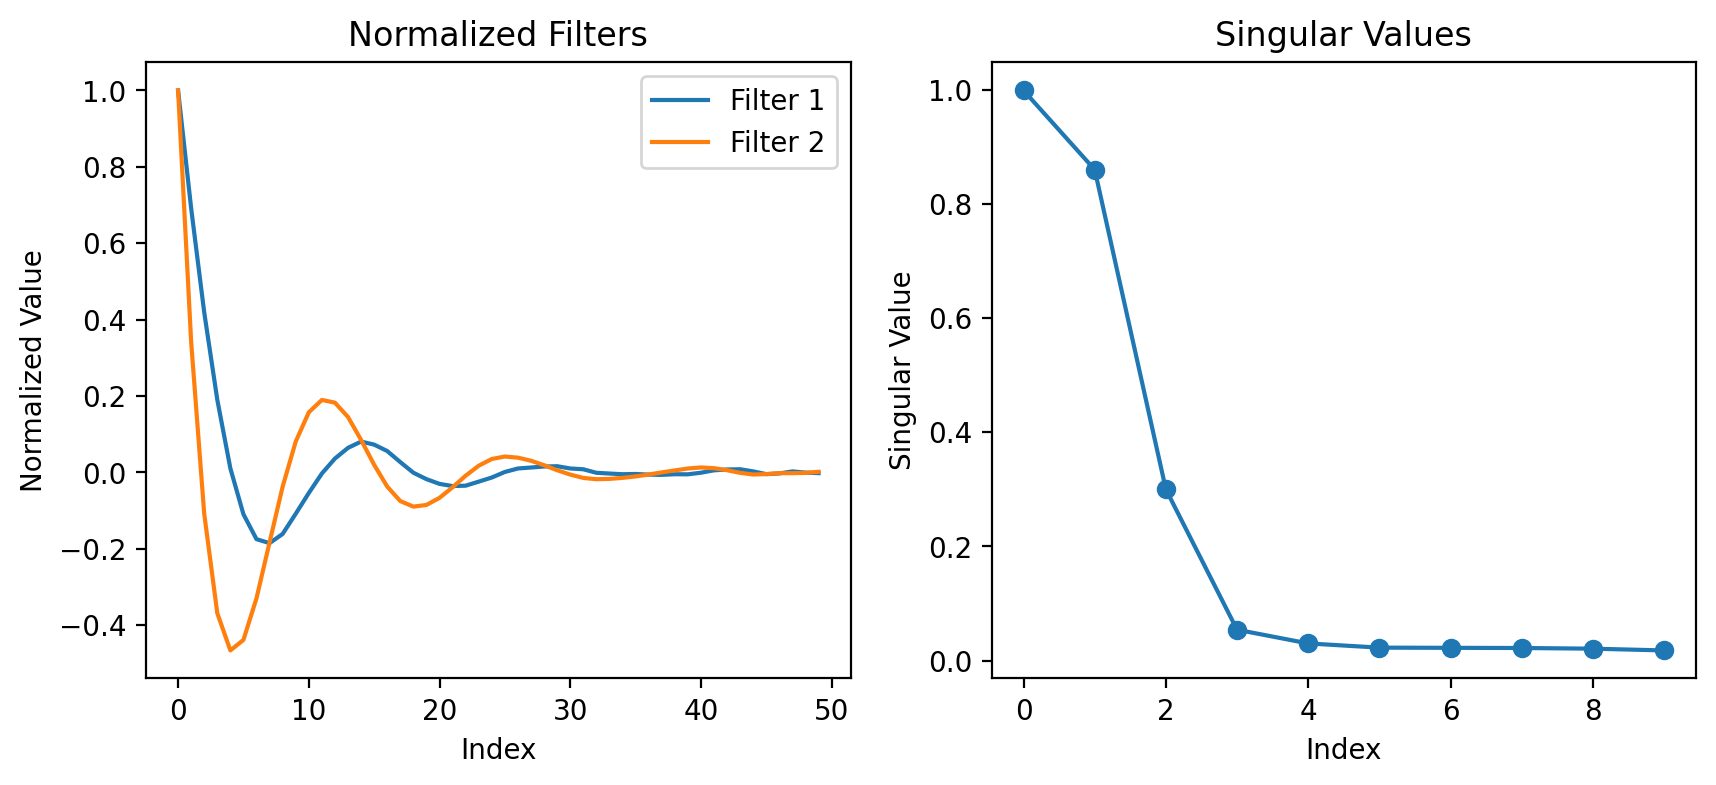

In [8]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
# plot the first 3 filters
for i in range(2):
    ax[0].plot(normalized_filters3[i, :], label=f'Filter {i+1}')
ax[0].set_title('Normalized Filters')
ax[0].set_xlabel('Index')
ax[0].set_ylabel('Normalized Value')    
ax[0].legend()
# plot the singular values
ax[1].plot(S3[:10], 'o-')        
ax[1].set_title('Singular Values')    
ax[1].set_xlabel('Index')    
ax[1].set_ylabel('Singular Value')    
plt.show()

### Second layer

In [9]:
def normalize_and_noise(x, noise_std=0.01):
    x_norm = x/np.std(x,axis=1,keepdims=True)
    x_noise = x_norm + np.random.normal(0,noise_std,x_norm.shape)
    return x_noise

# define a function that takes multiple pixels of input
def first_layer_out_multi(num_pixels, P, pixel_shift, delay, filters, noise_std = 0.01):
    '''
    num_pixels: number of pixels, an odd number >= 3
    Past: the past matrix
    pixel_shift: the shift of adjacent pixels
    delay: the delay of the past matrix
    filters: the filters, only the first two are used
    noise_std: the standard deviation of the noise
    return: the output of the first layer
    '''
    xs = [filters[:,:2].T @ P[:,i*pixel_shift:-(num_pixels-1-i)*pixel_shift] for i in range(num_pixels-1)]
    # add the last one
    xs.append(filters[:,:2].T @ P[:,(num_pixels-1)*pixel_shift:])
    # normalization and add noise
    xs_norm_noise = [normalize_and_noise(x, noise_std) for x in xs]

    for i in range(num_pixels):
        xs_norm_noise[i][1,:] = np.maximum(xs_norm_noise[i][1,:],0)
    # add delay
    xs_delay = [x[:,:-delay] for x in xs_norm_noise]

    # compose the past and future for the three pixel channels
    Pin = np.vstack(xs_delay)
    # Pinv = np.vstack(xs_delay[::-1])
    return Pin

# second layer matrix  multiple pixels
def second_layer_matrices_multi(num_pixels, P, pixel_shift, delay, filters, noise_std = 0.01, both_direction=False):
    '''
    num_pixels: number of pixels, an odd number >= 3
    Past: the past matrix
    pixel_shift: the shift of adjacent pixels
    delay: the delay of the past matrix
    filters: the filters, only the first two are used
    noise_std: the standard deviation of the noise
    return: the output of the second layer
    '''
    xs = [filters[:,:2].T @ P[:,i*pixel_shift:-(num_pixels-1-i)*pixel_shift] for i in range(num_pixels-1)]
    # add the last one
    xs.append(filters[:,:2].T @ P[:,(num_pixels-1)*pixel_shift:])
    # normalization and add noise
    xs_norm_noise = [normalize_and_noise(x, noise_std) for x in xs]

    # rectify the second channel
    for i in range(num_pixels):
        xs_norm_noise[i][1,:] = np.maximum(xs_norm_noise[i][1,:],0)
    # add delay
    xs_delay = [x[:,:-delay] for x in xs_norm_noise]

    # compose the past and future for the three pixel channels
    Pin = np.vstack(xs_delay)

    xs_future = [x[:,delay:] for x in xs_norm_noise]
    Fin = np.vstack(xs_future)
    # Fin = np.vstack(xs_delay[::-1])
    Pinv = np.vstack(xs_delay[::-1])
    # reversed direction
    PinV = np.vstack(xs_delay[::-1])
    FinV = np.vstack(xs_future[::-1])
    # objective function
    num_sample = Pin.shape[1]
    Q = Fin@Pin.T/num_sample
    # Compute SVD of partially whittened covariance
    Rp = Pin@Pin.T/num_sample
    Rf = Fin@Fin.T/num_sample
    if both_direction:
        Q += FinV@PinV.T/num_sample
        # Compute SVD of partially whittened covariance
        Rp += PinV@PinV.T/num_sample
        Rf += FinV@FinV.T/num_sample
    Rp_half = sqrtm(Rp)
    Rf_half = sqrtm(Rf)
    return Q, Rp_half, Rf_half

# define the first layer output of past lag vector matrices
def first_layer_output(Past, pixel_shift, delay, filters, noise_std = 0.01):
    P_preferred = []
    P_null = []
    for P in Past:
        x_l = filters[:,:2].T @ P[:,:-2*pixel_shift]
        x_c = filters[:,:2].T @ P[:,pixel_shift:-pixel_shift]
        x_r = filters[:,:2].T @ P[:,2*pixel_shift:]

        # normalize and add noise
        x_l = x_l/np.std(x_l,axis=1,keepdims=True)
        x_c = x_c/np.std(x_c,axis=1,keepdims=True)
        x_r = x_r/np.std(x_r,axis=1,keepdims=True)
        x_l = x_l + np.random.normal(0,noise_std,x_l.shape)
        x_c = x_c + np.random.normal(0,noise_std,x_c.shape)
        x_r = x_r + np.random.normal(0,noise_std,x_r.shape)
        
        # rectify the 2nd component of each channel
        x_l[1,:] = np.maximum(x_l[1,:],0)
        x_c[1,:] = np.maximum(x_c[1,:],0)
        x_r[1,:] = np.maximum(x_r[1,:],0)

        # compose past and future for three pixel channel
        Pin = np.vstack([x_l[:,:-delay],x_c[:,:-delay],x_r[:,:-delay]])
        P_preferred.append(Pin)

        # null direction past
        PinV = np.vstack([x_r[:,:-delay],x_c[:,:-delay],x_l[:,:-delay]])
        P_null.append(PinV)
    # transform the list to array
    P_preferred = np.array(P_preferred)
    P_null = np.array(P_null)

    return P_preferred, P_null

# out put of the first layer
def second_layer_matrices(Past, pixel_shift, delay, filters, noise_std = 0.01, both_direction = False):
    '''
    Past:   a list of past vector matrices
    pixel_shift: the shift of the pixel to be predicted, integer
    dely:  when construct the input for the 2nd layer
    filters: the filters of the first layer, columns are the filters
    '''
    Q = 0
    Rp = 0
    Rf = 0
    count = 0
    for P in Past:
        x_l = filters[:,:2].T @ P[:,:-2*pixel_shift]
        x_c = filters[:,:2].T @ P[:,pixel_shift:-pixel_shift]
        x_r = filters[:,:2].T @ P[:,2*pixel_shift:]

        # normalize and add noise
        x_l = x_l/np.std(x_l,axis=1,keepdims=True)
        x_c = x_c/np.std(x_c,axis=1,keepdims=True)
        x_r = x_r/np.std(x_r,axis=1,keepdims=True)
        x_l = x_l + np.random.normal(0,noise_std,x_l.shape)
        x_c = x_c + np.random.normal(0,noise_std,x_c.shape)
        x_r = x_r + np.random.normal(0,noise_std,x_r.shape)
        
        # rectify the 2nd component of each channel
        x_l[1,:] = np.maximum(x_l[1,:],0)
        x_c[1,:] = np.maximum(x_c[1,:],0)
        x_r[1,:] = np.maximum(x_r[1,:],0)
        
        # compose past and future for three pixel channel
        Pin = np.vstack([x_l[:,:-delay],x_c[:,:-delay],x_r[:,:-delay]])
        Fin = np.vstack([x_l[:,delay:],x_c[:,delay:],x_r[:,delay:]])
        # null direction past
        PinV = np.vstack([x_r[:,:-delay],x_c[:,:-delay],x_l[:,:-delay]])
        FinV = np.vstack([x_r[:,delay:],x_c[:,delay:],x_l[:,delay:]])

        # objective function
        num_sample = Pin.shape[1]
        Q += Fin@Pin.T/num_sample
        # Compute SVD of partially whittened covariance
        Rp += Pin@Pin.T/num_sample
        Rf += Fin@Fin.T/num_sample
        if both_direction:
            Q += FinV@PinV.T/num_sample
            # Compute SVD of partially whittened covariance
            Rp += PinV@PinV.T/num_sample
            Rf += FinV@FinV.T/num_sample
        count += 1
    Q = Q/count
    Rf = Rf/count
    Rp = Rp/count
    Rp_half = sqrtm(Rp)
    Rf_half = sqrtm(Rf)
    return Q, Rp_half, Rf_half

# define a function to stack the 2nd layer
def stack_second_layer_channel(Yin, lag):
    """
    Yin:    a list of past vector matrices
    lag:    the lag of the past vector matrices
    """
    L = Yin.shape[-1] - lag+1
    P_array = np.zeros((3*(lag+1),L))
    for i in range(3):
        P_array[i*(lag+1),:] = Yin[i,lag-1:]
        P_array[i*(lag+1)+1:(i+1)*(lag+1),:] = hankel(Yin[i][:lag],Yin[i][lag-1:]) 
    return P_array

# Add lag to the second layer
def second_layer_lag(Past, lag, pixel_shift, delay, filters, noise_std = 0.01, both_direction = False):
    '''
    Past:   a list of past vector matrices
    lag:    the lag of the past vector matrices
    pixel_shift: the shift of the pixel to be predicted, integer
    delay:  when construct the input for the 2nd layer
    filters: the filters of the first layer, columns are the filters
    '''
    Q = 0
    Rp = 0
    Rf = 0
    count = 0
    for P in Past:
        x_l = filters[:,:2].T @ P[:,:-2*pixel_shift]
        x_c = filters[:,:2].T @ P[:,pixel_shift:-pixel_shift]
        x_r = filters[:,:2].T @ P[:,2*pixel_shift:]

        # normalize and add noise
        x_l = x_l/np.std(x_l,axis=1,keepdims=True)
        x_c = x_c/np.std(x_c,axis=1,keepdims=True)
        x_r = x_r/np.std(x_r,axis=1,keepdims=True)
        x_l = x_l + np.random.normal(0,noise_std,x_l.shape)
        x_c = x_c + np.random.normal(0,noise_std,x_c.shape)
        x_r = x_r + np.random.normal(0,noise_std,x_r.shape)
        
        # rectify the 2nd component of each channel
        x_l[1,:] = np.maximum(x_l[1,:],0)
        x_c[1,:] = np.maximum(x_c[1,:],0)
        x_r[1,:] = np.maximum(x_r[1,:],0)

    
        # compose past and future for three pixel channel
        Yin = np.vstack([x_l[:,:-delay],x_c[:,:-delay],x_r[:,:-delay]])
        Pin = stack_second_layer_channel(Yin, lag)
        Yin = np.vstack([x_l[:,delay:],x_c[:,delay:],x_r[:,delay:]])
        Fin = stack_second_layer_channel(Yin, lag)

        # null direction past
        Yin = np.vstack([x_r[:,:-delay],x_c[:,:-delay],x_l[:,:-delay]])
        PinV = stack_second_layer_channel(Yin, lag)
        Yin = np.vstack([x_r[:,delay:],x_c[:,delay:],x_l[:,delay:]])
        FinV = stack_second_layer_channel(Yin, lag)
        # objective function
        num_sample = Pin.shape[1]
        Q += Fin@Pin.T/num_sample
        # Compute SVD of partially whittened covariance
        Rp += Pin@Pin.T/num_sample
        Rf += Fin@Fin.T/num_sample
        if both_direction:
            Q += FinV@PinV.T/num_sample
            # Compute SVD of partially whittened covariance
            Rp += PinV@PinV.T/num_sample
            Rf += FinV@FinV.T/num_sample
        count += 1
    Q = Q/count
    Rf = Rf/count
    Rp = Rp/count
    Rp_half = sqrtm(Rp + 1e-6*np.eye(Rp.shape[0])) # add a small number to avoid singularity
    Rf_half = sqrtm(Rf + 1e-6*np.eye(Rf.shape[0]))
    return Q, Rp_half, Rf_half
# define the input to the second layer
def second_layer_lag_input(P, lag, pixel_shift, delay, filters, noise_std = 0.01):
    '''
    P:   A Hanel matrix of past vector of the first layer
    lag:    the lag of the past vector matrices
    pixel_shift: the shift of the pixel to be predicted, integer
    delay:  when construct the input for the 2nd layer
    filters: the filters of the first layer, columns are the filters
    '''
    Pin = []
    PinV = []
    x_l = filters[:,:2].T @ P[:,:-2*pixel_shift]
    x_c = filters[:,:2].T @ P[:,pixel_shift:-pixel_shift]
    x_r = filters[:,:2].T @ P[:,2*pixel_shift:]

    # normalize and add noise
    x_l = x_l/np.std(x_l,axis=1,keepdims=True)
    x_c = x_c/np.std(x_c,axis=1,keepdims=True)
    x_r = x_r/np.std(x_r,axis=1,keepdims=True)
    x_l = x_l + np.random.normal(0,noise_std,x_l.shape)
    x_c = x_c + np.random.normal(0,noise_std,x_c.shape)
    x_r = x_r + np.random.normal(0,noise_std,x_r.shape)
    
    # rectify the 2nd component of each channel
    x_l[1,:] = np.maximum(x_l[1,:],0)
    x_c[1,:] = np.maximum(x_c[1,:],0)
    x_r[1,:] = np.maximum(x_r[1,:],0)

    # compose past and future for three pixel channel
    Yin = np.vstack([x_l[:,:-delay],x_c[:,:-delay],x_r[:,:-delay]])
    Pin = stack_second_layer_channel(Yin, lag)

    Yin = np.vstack([x_r[:,:-delay],x_c[:,:-delay],x_l[:,:-delay]])
    PinV = stack_second_layer_channel(Yin, lag)

    return Pin, PinV


def reshape_cov_mat(C,spatial_size, time_lag = 7, reverse=False):
    '''
    Reshape the spatial-temporal covariance matrix for the nearest kronecker prodcut approximation
    '''
    # get the size of the covariance matrix
    n = spatial_size
    m = time_lag
    assert C.shape[0] == n*m, "The size of the covariance matrix is not correct"

    # define the shape of the new covariance matrix
    if reverse:
        new_cov = np.zeros((n*n, m*m))
        for i in range(n):
            for j in range(n):
                block = C[j*m:(j+1)*m,i*m:(i+1)*m]
                # flatten the block column wise and set it as the row of the new covariance matrix
                new_cov[i*n+j,:] = block.flatten('F')
                # new_cov[i*m+j,:] = np.kron(C[i*n:(i+1)*n,j*n:(j+1)*n])
    else:
        new_cov = np.zeros((m*m, n*n))
        for i in range(m):
            for j in range(m):
                block = C[j*n:(j+1)*n,i*n:(i+1)*n]
                # flatten the block column wise and set it as the row of the new covariance matrix
                new_cov[i*m+j,:] = block.flatten()
            # new_cov[i*m+j,:] = np.kron(C[i*n:(i+1)*n,j*n:(j+1)*n])

    return new_cov

In [10]:
# using lag fo the second layer
filters_layer1 = filter3[:3,:].T
# normalize the filters such that the largest element is 1
# filters_layer1 = filters_layer1/np.max(np.abs(filters_layer1),axis=0,keepdims=True)

pixel_shift = 13
delay = 5
# # time_lag = 3 # lag for the second layer
# Q2,Rp2_half,Rf_2_half = second_layer_lag([P_train], time_lag, pixel_shift, delay, filters_layer1, \
#                                          noise_std = 0.01, both_direction = True)
Q2,Rp2_half,Rf_2_half = second_layer_matrices([P_train], pixel_shift, delay, filters_layer1, \
                                              noise_std = 0.01, both_direction = False)

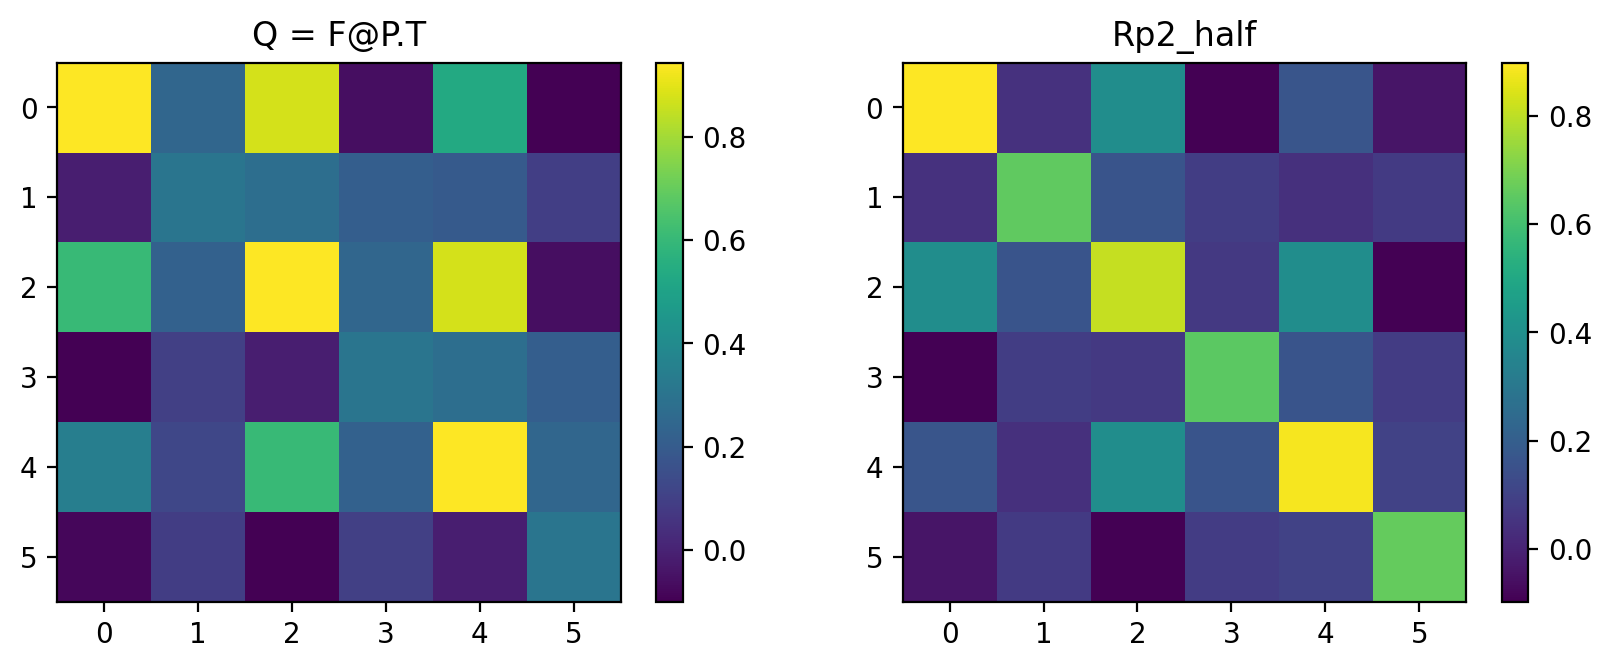

In [11]:
# make  1 by 2 grid of plots the first Q2, the second Rp2_half
fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
plt.subplot(1, 2, 1)
plt.imshow(Q2, aspect='auto')
plt.colorbar()
# add title
plt.title('Q = F@P.T')

# Q.shape
plt.subplot(1, 2, 2)
plt.imshow(np.real(Rp2_half), aspect='auto')
plt.colorbar()
plt.title('Rp2_half')
# R.shape
plt.show()

In [12]:
# filters = filter3[:3,:].T
# pixel_shift = 25
# delay = 5
# shift and delay
# Q2,Rp2_half,Rf_2_half = second_layer_matrices([P_train], pixel_shift, delay, filters, noise_std = 0.01, both_direction = False)
W_2nd = np.linalg.inv(Rf_2_half)@Q2@np.linalg.inv(Rp2_half).T
# SVD
U2, S2, Vh2 = sp.linalg.svd(W_2nd,full_matrices=False)
v22 = Vh2.T
filter_2nd_layer = Vh2@np.linalg.inv(Rp2_half)

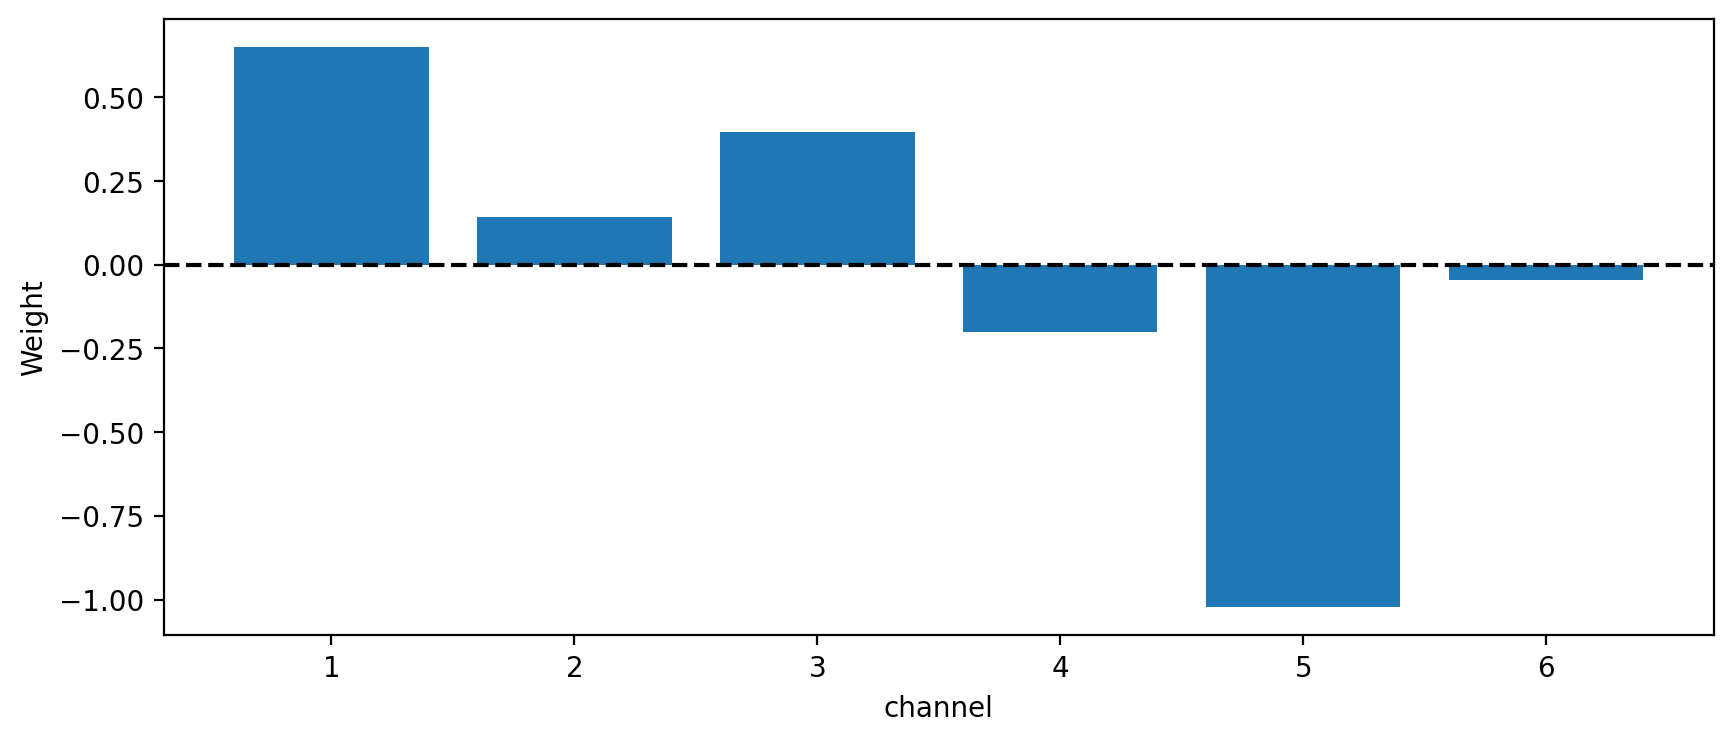

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))
# channels = ['L3_l', 'L1_1', 'L3_c', 'L1_c', 'L3_r', 'L1_r']
channels = np.arange(1,filter_2nd_layer.shape[1]+1)


ax.bar(channels, filter_2nd_layer[1,:].T)
# # add x and y labels
ax.set_xlabel('channel')
ax.set_ylabel('Weight')
# # remove tickets of the axis
# ax.tick_params(axis='both', which='both', length=0)
# add horizontal line at 0 with dashed line
ax.axhline(y=0, color='k', linestyle='--')
plt.show()
# save the figure as a 

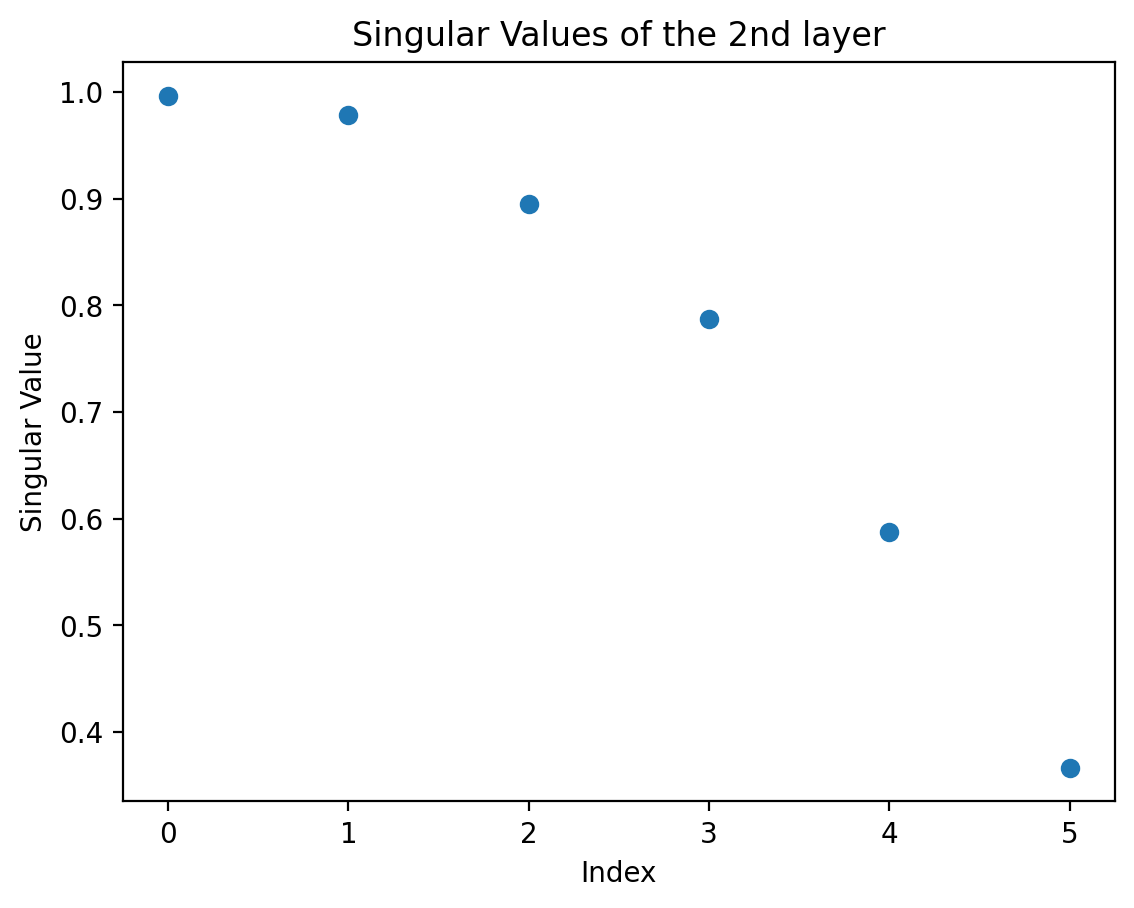

In [14]:
fig,ax = plt.subplots()
plt.plot(S2[:], 'o')
plt.title('Singular Values of the 2nd layer')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.show()

### Test the learned filters in the 2nd layer
We use the sinusoidal signal not used during training to compare the null and preferred direction

#### Tanh transients

In [15]:
# define the input signal, a time series
x = np.arange(-200, 200) / 20
r2_part = np.tanh(x)
pattern = [r2_part, r2_part[::-1], r2_part, -r2_part, -r2_part[::-1], -r2_part, -r2_part[::-1], r2_part[::-1]]
r2 = np.concatenate(pattern + [r2_part, r2_part[::-1]])
# Add noise

noise_std = 0.005
tanh_noise = r2 + np.random.randn(len(r2)) * noise_std + 1

H = hankel(tanh_noise[:memory+horizon], tanh_noise[memory+horizon-1:])  # hankel(c, r): first column and last row
P = H[:memory, :].T
P = np.fliplr(P)     # flip left/right
F = H[memory:, :].T  # shape: (number_of_columns, half_L)


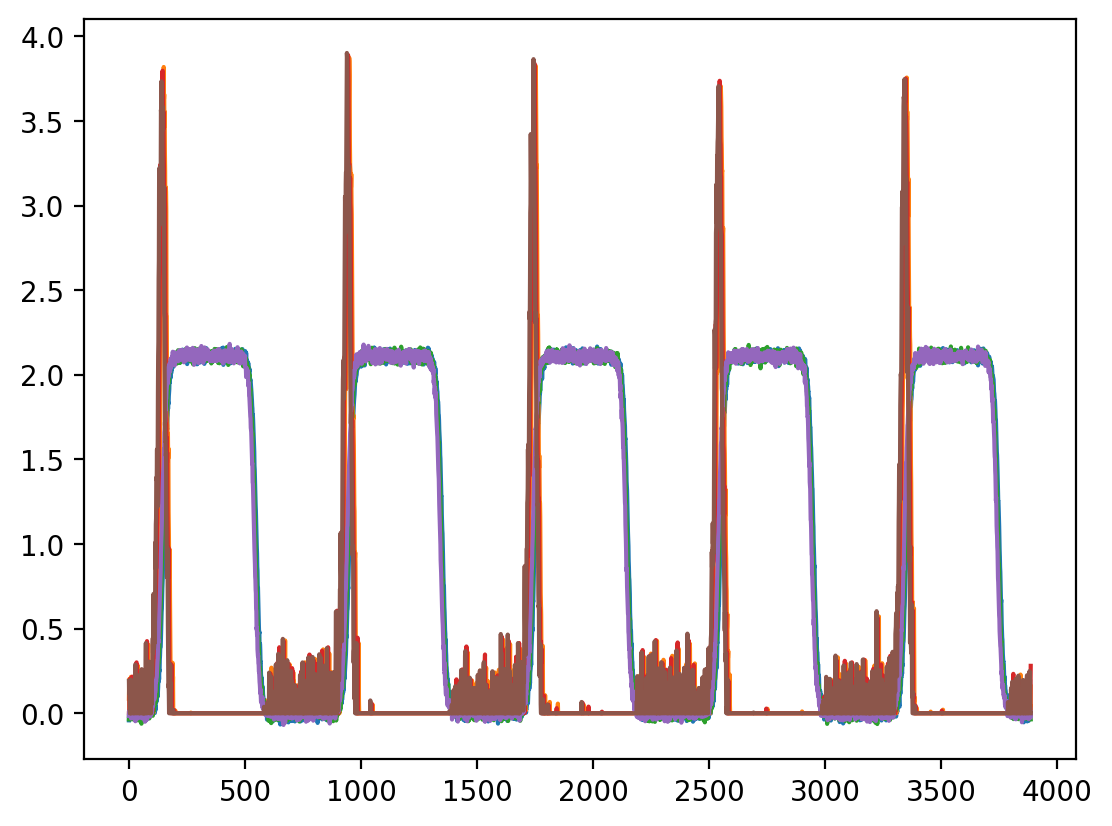

In [16]:
# Past
# prefferred and null direction
noise_std = 0.02
Pin, PInV = first_layer_output([P.T], 5, delay, filters_layer1, noise_std)
Pin = Pin.squeeze()
PInV = PInV.squeeze()

plt.plot(Pin.T)
plt.show()

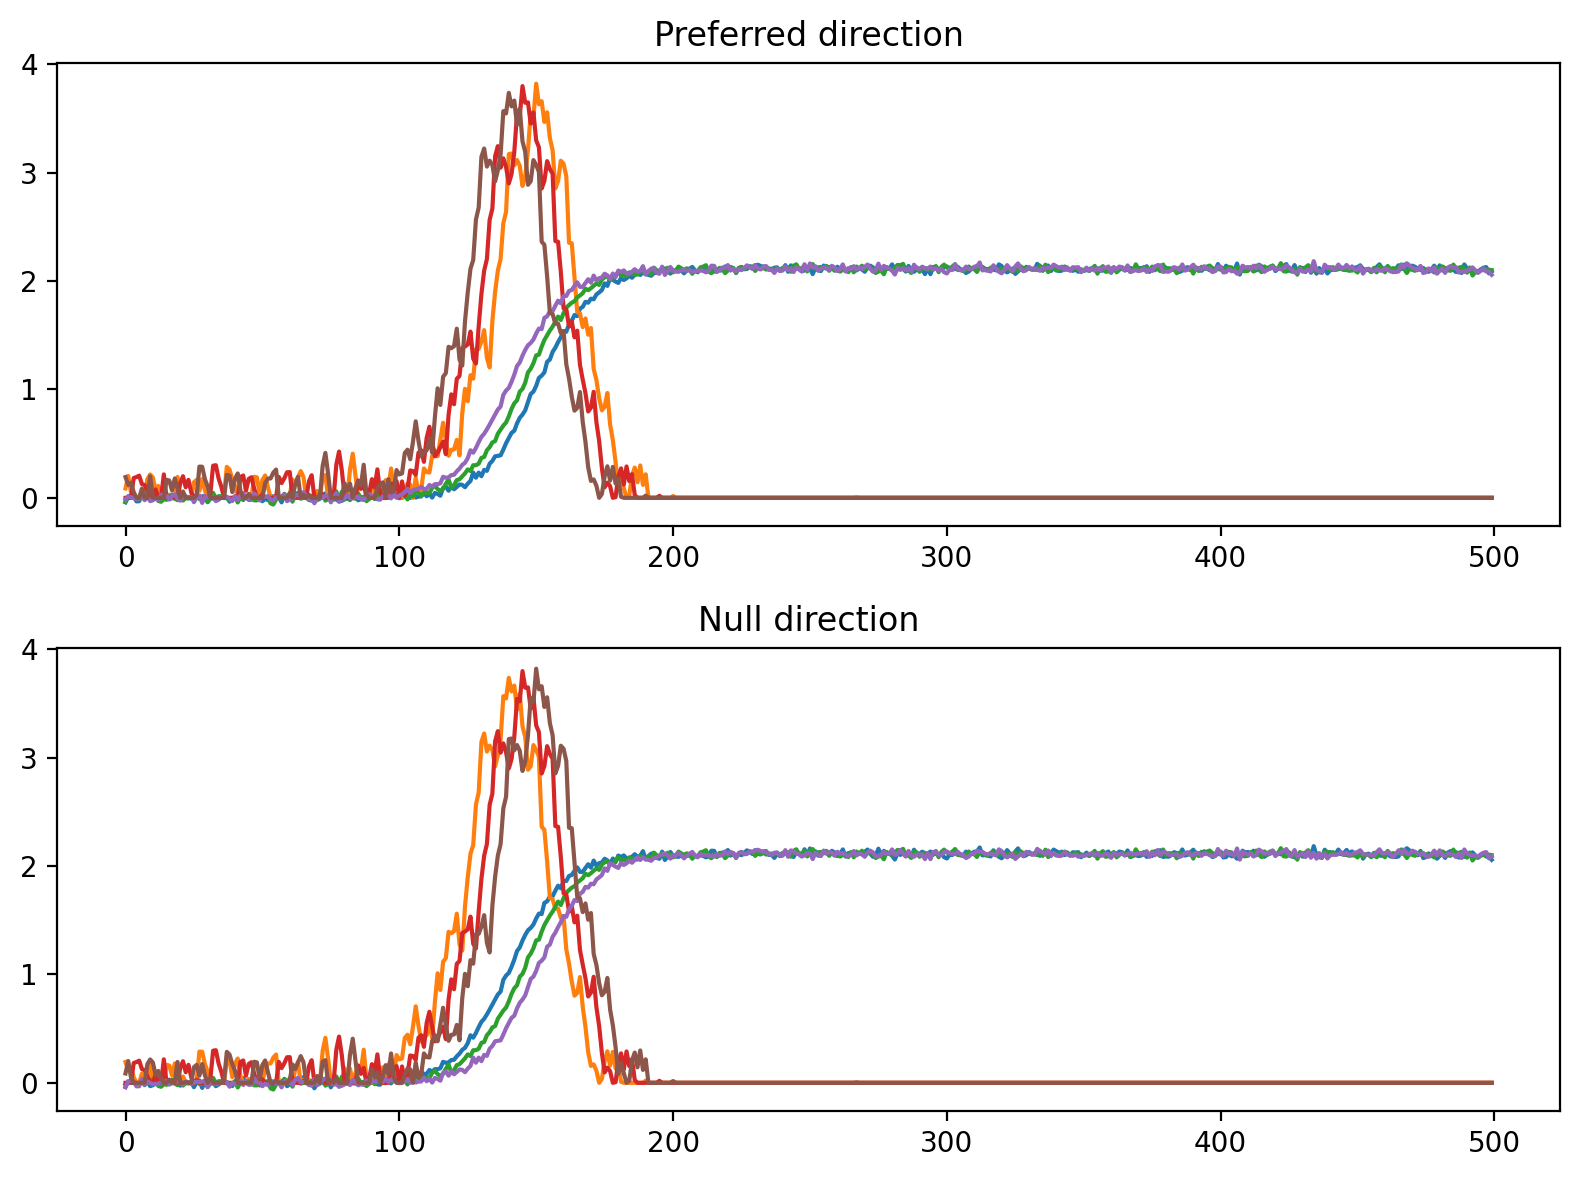

In [17]:
fig, ax = plt.subplots(2,1,figsize=(8, 6))
ax[0].plot(Pin[:,:500].T)
ax[0].set_title('Preferred direction')
ax[1].plot(PInV[:,:500].T)
ax[1].set_title('Null direction')
plt.tight_layout()
plt.show()
# plt.plot(Pin[:,:500].T)

In [18]:
def plot_2nd_response(traj, horizon,Pin, PInV, filter_2nd_layer, mode_sel=1,zs=True,rectify=False):
    '''A2
    traj: the input signal
    Pin: the preferred direction
    PInV: the null direction
    filter_2nd_layer: the filters, each column is a filter
    mode_sel: the selected mode
    '''
    # Compute the projections
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    resp_preferred = Pin.T @ filter_2nd_layer[:, mode_sel].reshape(-1, 1).flatten()
    resp_null = PInV.T @ filter_2nd_layer[:, mode_sel].reshape(-1, 1).flatten()
    if rectify:
        resp_preferred = np.maximum(resp_preferred, 0)
        resp_null = np.maximum(resp_null, 0)
    if zs:
        resp_preferred = zscore(resp_preferred)
        resp_null = zscore(resp_null)
    plt.plot(resp_preferred, label='preferred')
    plt.plot(resp_null, label='null')
    # plt.plot(zscore(Pin.T @ filter_2nd_layer[:, mode_sel].reshape(-1, 1)).flatten(), label='preferred')    
    # plt.plot(zscore(PInV.T @ filter_2nd_layer[:, mode_sel].reshape(-1, 1)).flatten(), label='null')
    plt.plot(traj[horizon:], label='input', color='gray', alpha=0.5)
    plt.legend()
    # plt.title("Mode projections")
    # add x and y labels
    
    plt.xlabel('Time')  
    plt.ylabel('Response')
    plt.tight_layout()

    plt.subplot(2, 1, 2)
    plt.plot(np.arange(1,1+len(filter_2nd_layer[:,mode_sel])),filter_2nd_layer[:,mode_sel],'-o')
    # add a horizontal line at 0
    plt.axhline(0, color='gray', linestyle='--')
    # plt.title("v22, selected mode")
    # add x and y labels
    plt.xlabel('Index')
    plt.ylabel('Weight')
    # set x ticks [0, 5, 10, 15]
    # plt.xticks([0, 5, 10, 15])
    plt.tight_layout()

    plt.show()  

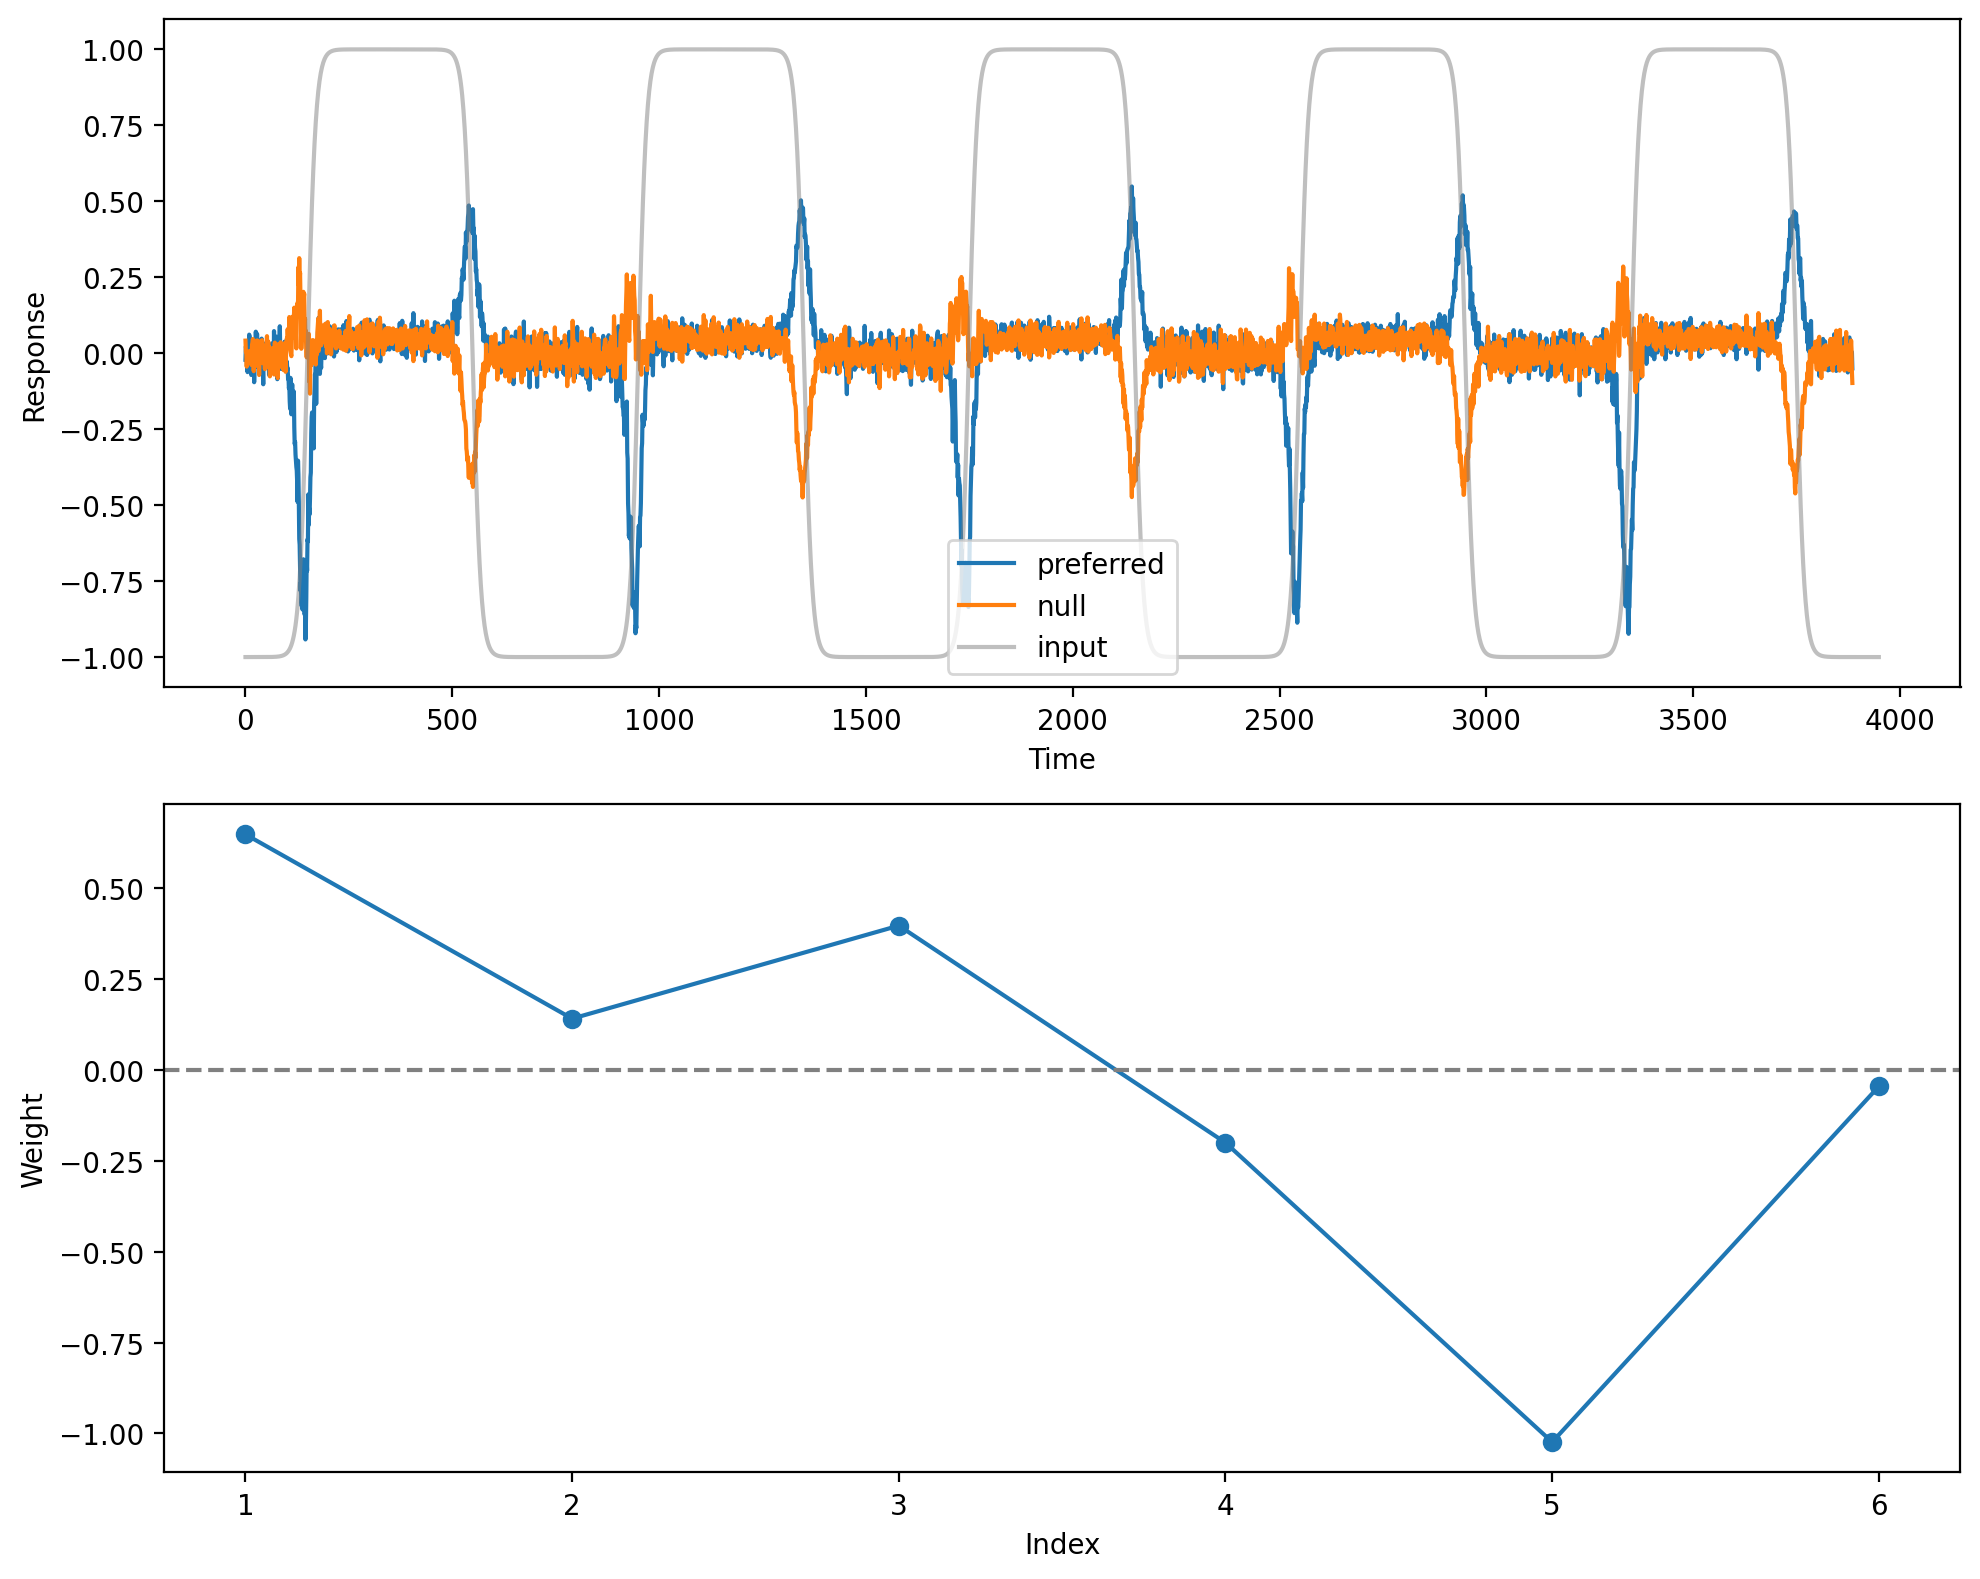

In [19]:
plot_2nd_response(r2, horizon,Pin, PInV, filter_2nd_layer.T, mode_sel=1,zs=False, rectify = False)

In [20]:

rectify = False
preferred_resp = Pin.T @ filter_2nd_layer.T[:, 1].reshape(-1, 1).flatten()
null_resp = PInV.T @ filter_2nd_layer.T[:, 1].reshape(-1, 1).flatten()
if rectify:
    preferred_resp = np.maximum(preferred_resp, 0)
    null_resp = np.maximum(null_resp, 0)
# null_resp = zscore(PInV.T @ filter_2nd_layer[:, mode_sel].reshape(-1, 1)).flatten()

# save the data
np.savez("./results/fig3_preferred_null_response.npz", preferred_resp = preferred_resp, null_resp = null_resp,\
         test_traj = r2, filter_2nd_layer = filter_2nd_layer, Pin = Pin, PInV = PInV)